## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 10s 194us/step - loss: 1.6144 - accuracy: 0.5264 - val_loss: 1.6837 - val_accuracy: 0.4977
Epoch 49/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6112 - accuracy: 0.5245 - val_loss: 1.6694 - val_accuracy: 0.4977
Epoch 50/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.6082 - accuracy: 0.5280 - val_loss: 1.7137 - val_accuracy: 0.4934
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

50000/50000 [==============================] - 10s 193us/step - loss: 1.0697 - accuracy: 0.6736 - val_loss: 1.5887 - val_accuracy: 0.5155
Epoch 46/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.0575 - accuracy: 0.6771 - val_loss: 1.7596 - val_accuracy: 0.4812
Epoch 47/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.0447 - accuracy: 0.6830 - val_loss: 1.6699 - val_accuracy: 0.5025
Epoch 48/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.0348 - accuracy: 0.6872 - val_loss: 1.5421 - val_accuracy: 0.5367
Epoch 49/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.0167 - accuracy: 0.6921 - val_loss: 1.5821 - val_accuracy: 0.5191
Epoch 50/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.0153 - accuracy: 0.6944 - val_loss: 1.5591 - val_accuracy: 0.5269
Experiment with Regulizer = 0.000000
Model: "model_1"
___________________________________________________________

50000/50000 [==============================] - 10s 192us/step - loss: 0.9663 - accuracy: 0.6627 - val_loss: 1.3898 - val_accuracy: 0.5168
Epoch 43/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9493 - accuracy: 0.6668 - val_loss: 1.3991 - val_accuracy: 0.5192
Epoch 44/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9378 - accuracy: 0.6730 - val_loss: 1.4186 - val_accuracy: 0.5130
Epoch 45/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9268 - accuracy: 0.6756 - val_loss: 1.3834 - val_accuracy: 0.5260
Epoch 46/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.9120 - accuracy: 0.6805 - val_loss: 1.4014 - val_accuracy: 0.5237
Epoch 47/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.9003 - accuracy: 0.6854 - val_loss: 1.4194 - val_accuracy: 0.5239
Epoch 48/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.8893 - accuracy: 0.6910 - va

50000/50000 [==============================] - 10s 199us/step - loss: 1.0066 - accuracy: 0.6451 - val_loss: 1.3962 - val_accuracy: 0.5192
Epoch 40/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.9951 - accuracy: 0.6488 - val_loss: 1.3911 - val_accuracy: 0.5206
Epoch 41/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.9886 - accuracy: 0.6522 - val_loss: 1.3475 - val_accuracy: 0.5308
Epoch 42/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.9745 - accuracy: 0.6559 - val_loss: 1.4959 - val_accuracy: 0.4994
Epoch 43/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.9648 - accuracy: 0.6596 - val_loss: 1.3748 - val_accuracy: 0.5227
Epoch 44/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.9506 - accuracy: 0.6654 - val_loss: 1.3433 - val_accuracy: 0.5337
Epoch 45/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.9371 - accuracy: 0.6710 - va

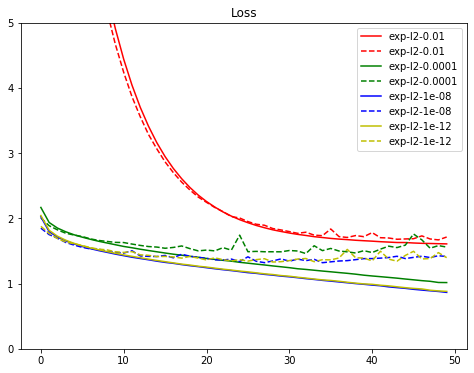

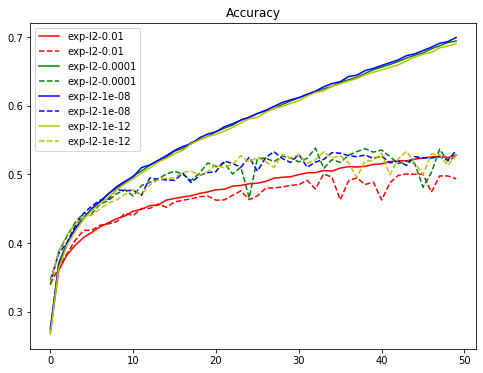

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果